# Regression Module Project: Estimating Zillow Home Value

### Project Scenario:
You are a junior data scientist on the __Zillow data science team__ and recieve the following email in your inbox:

__We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.__

We have a model already, but we are hoping your insights can help us improve it. __I need recommendations on a way to make a better model.__ Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

(One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in).

-- The Zillow Data Science Team



## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import get_zillow
from prepare import prepare_zillow



## Acquire prepped and split data

#### - Moving forward, train data will be used to prevent data leakage

In [2]:
train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


## Initial Data Explolatory Analysis

In [3]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,year_built,trans_date
16035,3.0,2.0,1522.0,64360.0,1925.0,2017-04-14
44800,2.0,1.0,900.0,338073.0,1951.0,2017-08-10
20047,2.0,1.0,807.0,51727.0,1951.0,2017-04-21
5077,3.0,3.0,2458.0,653996.0,1985.0,2017-02-16
36597,3.0,2.0,1386.0,242779.0,1962.0,2017-06-30


In [4]:
# Describe the data

train.describe()

,bed_count,bath_count,square_feet,assessed_value,year_built
count,29297.000000,29297.000000,29297.000000,2.929700e+04,29297.000000
mean,3.311773,2.303137,1922.911561,5.258636e+05,1963.286821
std,0.933666,1.012818,987.408513,7.157899e+05,23.128629
min,0.000000,0.000000,152.000000,9.242000e+03,1878.000000
25%,3.000000,2.000000,1270.000000,1.933730e+05,1950.000000
50%,3.000000,2.000000,1664.000000,3.724420e+05,1961.000000
75%,4.000000,3.000000,2312.000000,6.190000e+05,1979.000000
max,12.000000,11.000000,21929.000000,2.434570e+07,2016.000000


In [5]:
# Get data summary information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29297 entries, 16035 to 39200
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed_count       29297 non-null  float64
 1   bath_count      29297 non-null  float64
 2   square_feet     29297 non-null  float64
 3   assessed_value  29297 non-null  float64
 4   year_built      29297 non-null  float64
 5   trans_date      29297 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.6+ MB


In [6]:
# Check for null values
train.isnull().sum()

bed_count         0
bath_count        0
square_feet       0
assessed_value    0
year_built        0
trans_date        0
dtype: int64

In [7]:
# Any null columns?
train.columns.isnull().any()

False

In [8]:
# Value counts
train.value_counts()

bed_count  bath_count  square_feet  assessed_value  year_built  trans_date
0.0        0.0         400.0        49627.0         1950.0      2017-05-01    1
4.0        2.0         1580.0       221604.0        1977.0      2017-01-06    1
                       1578.0       397610.0        1978.0      2017-05-02    1
                                    96458.0         1959.0      2017-06-16    1
                       1577.0       432902.0        1959.0      2017-07-20    1
                                                                             ..
3.0        2.0         1336.0       965007.0        1946.0      2017-01-26    1
                                    569000.0        1953.0      2017-06-02    1
                                    464000.0        1956.0      2017-06-22    1
                                    432168.0        1980.0      2017-06-20    1
12.0       6.0         8469.0       2485282.0       1909.0      2017-06-09    1
Length: 29297, dtype: int64

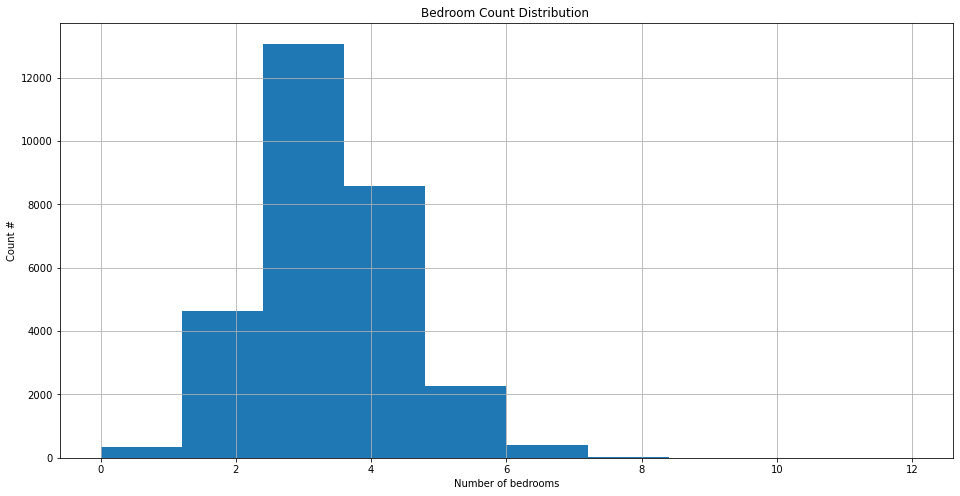

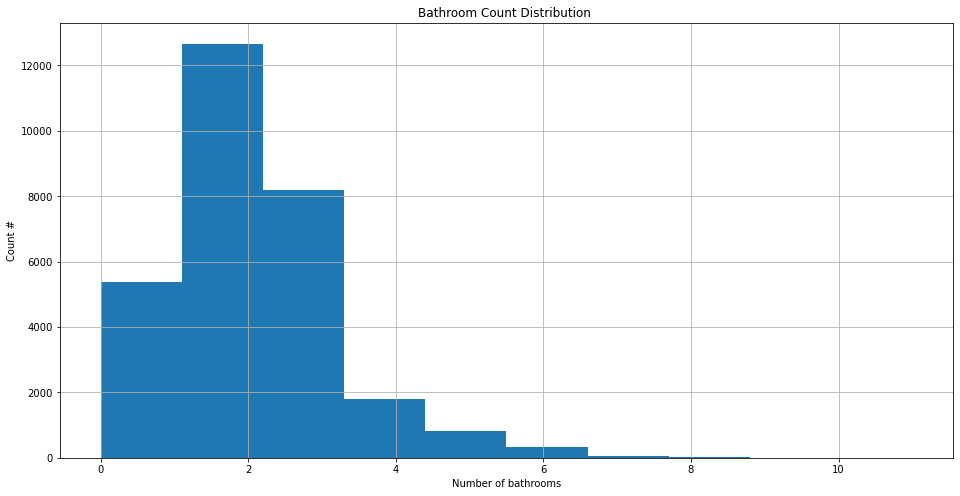

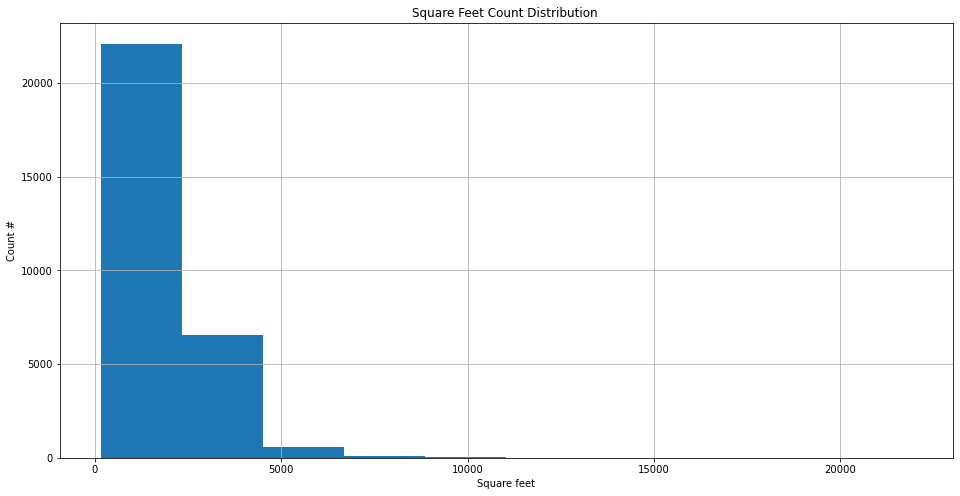

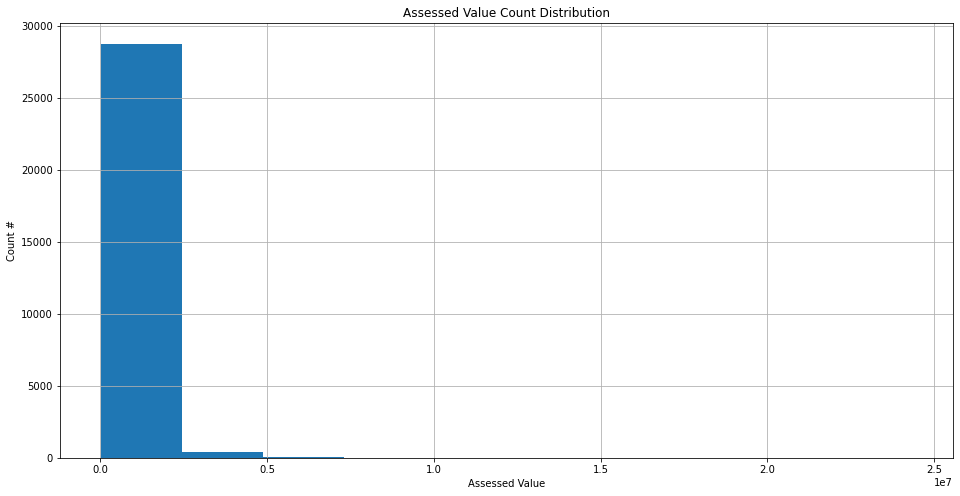

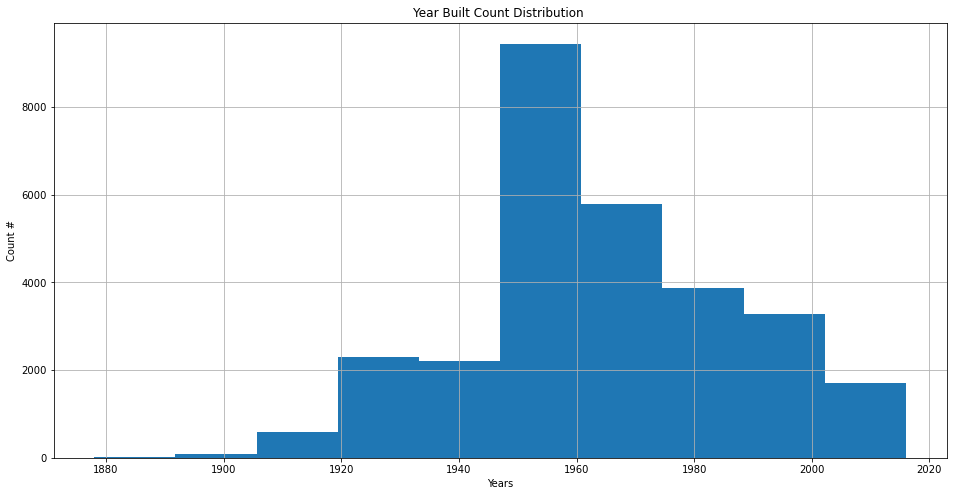

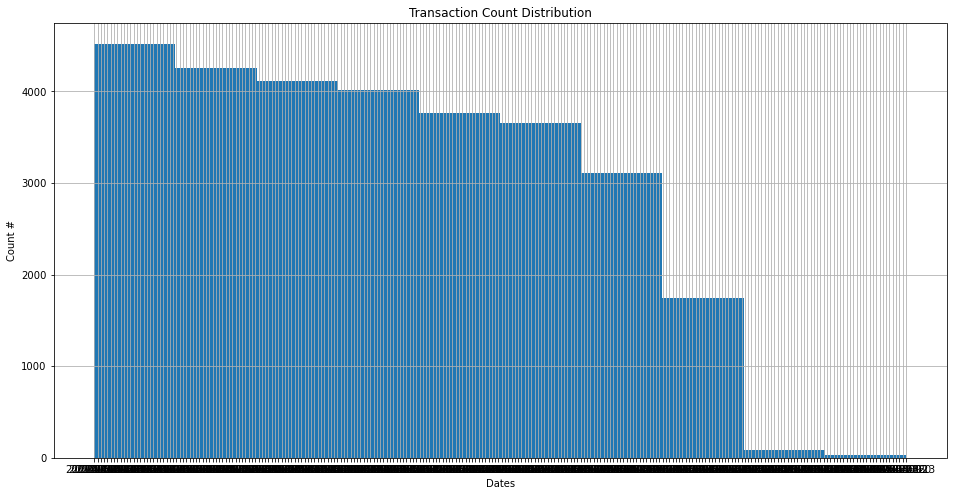

In [19]:
# Initial Visualizations
plt.figure(figsize = (16, 8))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Square Feet Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Assessed Value Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Assessed Value')
train.assessed_value.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Year Built Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Years')
train.year_built.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Transaction Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Dates')
train.trans_date.hist()
plt.show()

#### Need to fix** 
- First 5 columns data end with 0. Some 0 are not really required
- All data in this dataframe are from 2017,  the trans_date columns need be split into month and maybe days(preferably months)
- Bathroom, bathroom and year built are faily normally distributed
- Further cleaning on Transaction date required

## Data Scalling 

## <u>Key Findings:</u>

#### NOTE: All homes in dataset are zillow homes of 2017

- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017 
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s. 
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s. 
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Homes between 



# Exploration Phase: 

## Hypothesis Formulation & Testing

##  Exploration Visualizations

## Exploration Testing

# Modeling Phase: 

## Feature Engineering

## Establish Baseline

## Build Models

## Model Evaluations

## Model Selection & Testing

# Conclusions and Delivery: 